## PUTSAFIRST

-----------------------------------------
### DIFFUSION ANALYSIS


Diffusion analysis is the study of how interpersonal ties amplify the spread of a product, idea, or innovation such that a change in one person's behaviour cascades through a social network and produces a behavioural change in other people, communities, and populations.

#### Data Source

*#PutSAFirst Reply Network - Largest Component*


#### Data Transformation



Using the timestamp of when a tweet is created, I define the interaction point for node *A* and node *B* to be the point in time when either node *A* first replies to node *B* or vice versa. Any time before that point, a connection between node *A* and node *B* does not exist, and any time after that, a connection between node *A* and node *B* exists. I classify an undirected dynamic network where an "infection" can be transmitted in either direction and the choice to adopt is faced by either one (sender or receiver). Therefore, at any point when node *A* replies to node *B*, node *A* is aware of node *B*'s message, and at the same time, by directly replying to node *B*, node *B* is made aware of node *A*'s message. Once exposed, both are susceptible to "infection" and their decision to adopt is a combined function of their *threshold* to resist peer pressure and their personal *profile* or preference to only adopt when their interests are aligned.

#### Default Parameters



Threshold ($\tau$) = 60%

Profile ($\gamma$) = 25%  

For each simulation, I assume a passive threshold of 60% and active threshold of 25%. This means for any node to be susceptible, 60% of its neighbours should already be infected. Once this condition is met, a random number is drawn, if that number is above 25%, a node becomes infected. Initial adopters or seeds are selected from the top of each role list. Given the dynamic process, users eligible for seed selection are constrained by the date and time of their first tweet reply. An upper limit of 6 initial seeds is chosen for each simulation. Which means, depending on the diffusion period, each simulation can have up to 6 users as initial adopters.

Additionally, for the purposes of the analysis below, I define:

- **Activator (1)** seeds as nodes assigned to the *Activator* cluster sorted by feature values in the order: *outdegree*, *hierarchy*, *transitivity*, *reciprocity*, *#tweeted*, *betweenness*, and *closeness*. 
- **Activator (2)** seeds as nodes assigned to the *Activator* cluster sorted by feature values in the order: *betweenness*, *closeness*, *outdegree*, *hierarchy*, *transitivity*, *reciprocity*, and *#tweeted*.




#### Method



Using pythons ndlib and dynetx library, I present the dynamic **profile threshold model** and determine the diffusion process of discourse under varying seeds of adoption.


In [2]:
#
#import import_ipynb
#import os
import pandas as pd
import numpy as np
from scipy import stats
import igraph as ig
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import ipyplot
import plotly.express as px
from operator import itemgetter
import seaborn as sns 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from kneed import KneeLocator
import random
from numpy import random as nprando
from datetime import datetime, date, time, timedelta
import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.TrendComparison import DiffusionTrendComparison
from ndlib.viz.mpl.PrevalenceComparison import DiffusionPrevalenceComparison
#from bokeh.io import output_notebook, show
#from ndlib.viz.bokeh.DiffusionTrend import DiffusionTrend
#from ndlib.viz.bokeh.DiffusionPrevalence import DiffusionPrevalence
#from ndlib.viz.bokeh.MultiPlot import MultiPlot
import dynetx as dn
import ndlib.models.dynamic as dm
#import plotly.graph_objects as go
from IPython.display import Image, SVG, HTML, display
#from svglib.svglib import svg2rlg
#from reportlab.graphics import renderPM

#########################################################################################

##SETUP##
%matplotlib inline
sns.set()
nprando.seed(111)
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (12, 8)})
pd.set_option("display.max_columns",None)

##FUNCTIONS##
# Sort index order
def sort_index(lst, rev=True):
    index = range(len(lst))
    s = sorted(index, reverse=rev, key=lambda i: lst[i])
    return s


# Independent Cascade Model
def ic(G,s,d=[], a=[]):
    #print(s)
    jst_inf=list(s)
    infected=list(s)
    #flag = True
    while(1):
        #print(jst_inf, infected)
        # iteration ends when jst_infected list becomes empty
        if len(jst_inf)==0:
            return infected
            #flag = False
        tmp=[]
        for each in jst_inf:
            for each1 in G.neighbors(each, mode='all'):
                r = random.uniform(0,1)
                # if node in diffuser role, do not infect node
                if each1 in d:
                    r=0
                # if node in activator role, do not infect node
                if each1 in a:
                    r=0    
                # if node has random number less than 0.5, infect node
                if r>0.5 and each1 not in infected and each1 not in tmp:
                    tmp.append(each1)
            # overall infected nodes
            infected.append(each)
        # infected nodes in current iteration
        jst_inf=list(tmp)

##VARIABLES##
e_node = "putsafirst_nodes_1.csv"
e_kmean = "putsafirst_kmeans_1.csv"
e_vcomm = "putsafirst_vcomm_1_a.csv"
e_ecomm = "putsafirst_ecomm_1_a.csv"
e_edge = "putsafirst_edges_1.csv"
n=20
adopt = 0
block = 0
infect = 0.01
profile = 0.25
threshold = 0.6

#########################################################################################

##LOAD DATA##
df_node_1 = pd.read_csv(e_node, sep=";", dtype={'id': str})
#df_node_1.describe()  
df_edge_1 = pd.read_csv(e_edge, sep=";", dtype={'source': str, 'target': str, 'weight':int})
#df_edge_1.describe()
df_kmean_1 = pd.read_csv(e_kmean, sep=";", dtype={'id': str})
#df_kmean_1.describe()
df_vcomm_1 = pd.read_csv(e_vcomm, sep=",", dtype={'v_id_': str})
df_vcomm_1 = df_vcomm_1.rename(columns={"v_id_": "id_", 'label_':"label",'v_strength':"strength",'v_community_op':"community_op"})
#df_node_1.describe()  
df_ecomm_1 = pd.read_csv(e_ecomm, sep=",", dtype={'e_source_': str, 'e_target': str, 'Weight':int})
df_ecomm_1 = df_ecomm_1.rename(columns={"e_source_": "source_", 'e_target':"target_", 'Weight':"weight",'e_community_op':"community_op"})
#df_edge_1.describe()

##CONVERT TO UNDIRECTED GRAPH
#G_nx = nx.from_pandas_edgelist(df_edge_1, source='source', target='target', edge_attr=True, create_using=nx.DiGraph())
#G_nx = nx.from_pandas_edgelist(df_edge_1, source='source', target='target', edge_attr=True, create_using=nx.Graph())
#node_1 = df_node_1.set_index('id').to_dict('index')
#nx.set_node_attributes(G_nx, node_1)

G_ig=ig.Graph.DictList(df_node_1.to_dict('records'), df_edge_1.to_dict('records'), directed=True, vertex_name_attr='id', edge_foreign_keys=('source', 'target'))
#print(ig.summary(G_ig))
#print("\n" + "--------" + "\n" + '\033[1m' + 'Directed Network:' + '\033[0m' + "\n")
#print(ig.summary(G_ig))




--------
Number of Daily Interactions (Tweet Replies) in #PutSAFirst Discourse:



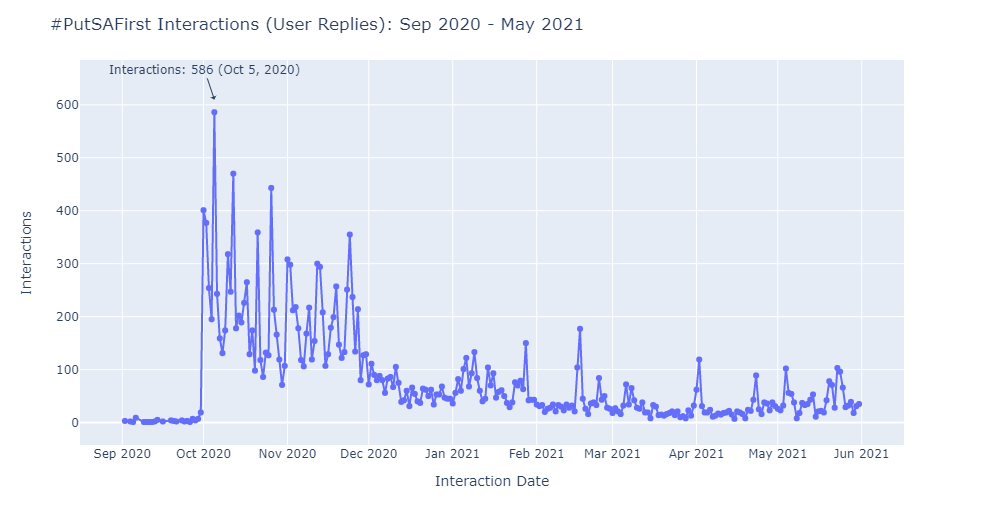

In [3]:
##CONVERT TO DYNAMIC IGRAPH
#DAILY TIMESTAMP SNAPSHOTS
d_node = df_node_1['date_tweet'].fillna("").to_list()
d_edge = df_edge_1['date_tweet'].fillna("").to_list()


d_edge_lst = []
d_edge_set = []
d_edge_lstlst = []
e_date_lst =[]
for each in d_edge:    
    dt_lst=list(each.split(','))
    #print(dt_lst)
    edates = list(filter(None, dt_lst))
    edates = sorted(edates, key=lambda edates: datetime.strptime(edates, '%Y-%m-%d'))
    d_e_1 = datetime.strptime(edates[0], '%Y-%m-%d')
    #print(d_e_1)
    e_date_lst.append(d_e_1)   

df_edge_1['date_e_1'] = list(map(lambda x:x.strftime('%Y-%m-%d'),e_date_lst))
e_time = sorted(set(e_date_lst), key=lambda e_date_lst: e_date_lst)
e_time_x = list(map(lambda x:x.strftime('%Y-%m-%d'),e_time)) 
#print(e_time_x)


##CONVERT TO DYNAMIC GRAPH##
G_dn0 = dn.DynGraph()
#G_dn = dn.DynDiGraph()


#dyn_edge = []
for i, t in enumerate(e_time_x):
    if datetime.strptime(t, '%Y-%m-%d') >= datetime.strptime("2020-09-01", '%Y-%m-%d') and datetime.strptime(t, '%Y-%m-%d') <= datetime.strptime("2021-05-31", '%Y-%m-%d'):
        #print(t)
        df_et=df_edge_1.loc[df_edge_1['date_e_1']==t]
        #print(df_et)
        dyn_edge = df_et[['source','target']].to_records(index=False)
        G_dn0.add_interactions_from(dyn_edge, t=i)
        
#print(G_dn.number_of_interactions())
        
#dn.write_interactions(G_dn, putsafirst_dyn_1)

#INTERACTION PLOT
#print(G_dn0.number_of_interactions())
dict_snap = G_dn0.interactions_per_snapshots()
#print(dict_snap)
inter_lst = list(dict_snap.keys())

dict_e_dt = {e:t for e,t in enumerate(e_time_x)}
#print(dict_e_dt)
#edge_date = e_time_x
#print(edge_date)


edge_date = []
for e,t in dict_e_dt.items():
    for k,i in dict_snap.items():
        if e==k:
            edge_date.append(t)

edge_inter = list(dict_snap.values()) 

#print(len(edge_inter))
#print(len(edge_date))
print("\n" + "--------" + "\n" + '\033[1m' + 'Number of Daily Interactions (Tweet Replies) in #PutSAFirst Discourse:' + '\033[0m' + "\n")
 

#plt.rcParams["figure.figsize"]=[10,5]
#plt.rcParams["figure.autolayout"] =True
#fig = px.line(x=edge_date,y=edge_inter, markers=True)
#fig.update_layout(xaxis_title= 'Interaction Date', yaxis_title= 'Interactions',  title = '#PutSAFirst Interactions (User Replies): Sep 2020 - May 2021')
#fig.add_annotation(x='2020-10-05', y=610, text="Interactions: 586 (Oct 5, 2020)", showarrow=True, arrowhead=1)
#plt.savefig("putsafirst_interactions_1.png")
#fig.show()

Image(filename="putsafirst_interactions_1.png",  width = "650")

In [4]:
#DAILY SNAPSHOTS
d_node = df_node_1['date_tweet'].fillna("").to_list()
d_edge = df_edge_1['date_tweet'].fillna("").to_list()

d_edge_lst = []
edates_16 = []
e_date_lst =[]
for each in d_edge:    
    dt_lst=list(each.split(','))
    #print(dt_lst)
    edates = list(filter(None, dt_lst))  
    edates = sorted(edates, key=lambda edates: datetime.strptime(edates, '%Y-%m-%d'))
    d_e_1 = datetime.strptime(edates[0], '%Y-%m-%d')
        #print(d_e_1)
    e_date_lst.append(d_e_1)
#print(e_date_lst)     

df_edge_1['date_ed_1'] = list(map(lambda x:x.strftime('%Y-%m-%d'),e_date_lst))
e_time = sorted(set(e_date_lst), key=lambda e_date_lst: e_date_lst)
e_time_x = list(map(lambda x:x.strftime('%Y-%m-%d'),e_time)) 
#print(e_time_x)


##CONVERT TO DYNAMIC GRAPH##
G_dn1 = dn.DynGraph()
G_dn2 = dn.DynGraph()
#G_dn = dn.DynDiGraph()
 
#dyn_edge = []
for i, t in enumerate(e_time_x):
    if datetime.strptime(t, '%Y-%m-%d') >= datetime.strptime("2020-09-01", '%Y-%m-%d') and datetime.strptime(t, '%Y-%m-%d') <= datetime.strptime("2021-05-31", '%Y-%m-%d'):
            #print(t)
        df_et=df_edge_1.loc[df_edge_1['date_ed_1']==t]
        #print(df_et)
        dyn_edge = df_et[['source','target']].to_records(index=False)
        G_dn1.add_interactions_from(dyn_edge, t=i)

#print(G_dn.number_of_interactions()) 
#674
      
for i, t in enumerate(e_time_x):
    if datetime.strptime(t, '%Y-%m-%d') >= datetime.strptime("2020-09-01", '%Y-%m-%d') and datetime.strptime(t, '%Y-%m-%d') < datetime.strptime("2020-10-5", '%Y-%m-%d'):
            #print(t)
        df_et2=df_edge_1.loc[df_edge_1['date_ed_1']==t]
        #print(df_et)
        dyn_edge2 = df_et2[['source','target']].to_records(index=False)
        G_dn2.add_interactions_from(dyn_edge2, t=i)

In [5]:
#OCTOBER 16 SNAPSHOTS
d_node = df_node_1['datetime_tweet'].fillna("").to_list()
d_edge = df_edge_1['datetime_tweet'].fillna("").to_list()

d_edge_lst = []
edates_16 = []
e_date_lst =[]
for each in d_edge:    
    dt_lst=list(each.split(','))
    #print(dt_lst)
    edates = list(filter(None, dt_lst))   
    edates = sorted(edates, key=lambda edates: datetime.strptime(edates, '%b %d %Y %H:%M:%S'))
    d_e_1 = datetime.strptime(edates[0], '%b %d %Y %H:%M:%S')
        #print(d_e_1)
    e_date_lst.append(d_e_1)
#print(e_date_lst)    
    #d_edge_lstlst.append(set(d_lst))
    #d_edge_lst.extend(d_lst)   

df_edge_1['date_e_1'] = list(map(lambda x:x.strftime('%b %d %Y %H:%M:%S'),e_date_lst))
e_time = sorted(set(e_date_lst), key=lambda e_date_lst: e_date_lst)
e_time_x = list(map(lambda x:x.strftime('%b %d %Y %H:%M:%S'),e_time)) 
#print(e_time_x)


##CONVERT TO DYNAMIC GRAPH##
G_dn = dn.DynGraph()
#G_dn = dn.DynDiGraph()
 
#dyn_edge = []
for i, t in enumerate(e_time_x):
    if datetime.strptime(t, '%b %d %Y %H:%M:%S') >= datetime.strptime("Oct 05 2020 00:00:00", '%b %d %Y %H:%M:%S') and datetime.strptime(t, '%b %d %Y %H:%M:%S') <= datetime.strptime("Oct 06 2020 00:00:00", '%b %d %Y %H:%M:%S'):
            #print(t)
        df_et=df_edge_1.loc[df_edge_1['date_e_1']==t]
        #print(df_et)
        dyn_edge = df_et[['source','target']].to_records(index=False)
        G_dn.add_interactions_from(dyn_edge, t=i)

#print(G_dn.number_of_interactions()) 
#534
      
    

In [6]:
# Parameters
role=['Leader','Activator (1)','Activator (2)','Observer']
n_lst = G_dn.nodes()
n2_lst = G_dn2.nodes()

df_kmean_1.sort_values(['pagerank', 'indegree', '#liked', '#retweeted', 'listed', 'tweets', 'following', 'followers'], inplace=True, ascending=False)
l_lst = (df_kmean_1['id'].loc[df_kmean_1['Position_3']=="Leader"]).to_list()
dl1=dict.fromkeys(l_lst)
dn1=dict.fromkeys(n_lst)
dn2=dict.fromkeys(n2_lst)
l_lst=[k for k in dict.fromkeys(x for x in dl1 if x in dn1)][:6]
l2_lst=[k for k in dict.fromkeys(x for x in dl1 if x in dn2)][:2]
#print(len(l_lst))
no_leader = len(l_lst)
no_leader2 = len(l2_lst)
leader = len(l_lst)/G_dn.number_of_nodes()
#print(leader) #0.047619047619047616

df_kmean_1.sort_values(['outdegree', 'hierarchy', 'transitivity', 'reciprocity', '#tweeted', 'betweenness', 'closeness'], inplace=True, ascending=False)
a_lst_1 = (df_kmean_1['id'].loc[df_kmean_1['Position_3']=="Activator"]).to_list()
da1=dict.fromkeys(a_lst_1)
dn1=dict.fromkeys(n_lst)
dn2=dict.fromkeys(n2_lst)
a_lst_1=[k for k in dict.fromkeys(x for x in da1 if x in dn1)][:6]
a2_lst_1=[k for k in dict.fromkeys(x for x in da1 if x in dn2)][:2]
#print(len(a_lst_1))
no_activator_1 = len(a_lst_1)
no_activator2_1 = len(a2_lst_1)
activator_1 = len(a_lst_1)/G_dn.number_of_nodes()
#print(activator_1) #0.047619047619047616

df_kmean_1.sort_values(['betweenness', 'closeness', 'outdegree', 'hierarchy', 'transitivity', 'reciprocity', '#tweeted'], inplace=True, ascending=False)
a_lst_2 = (df_kmean_1['id'].loc[df_kmean_1['Position_3']=="Activator"]).to_list()
dd1=dict.fromkeys(a_lst_2)
dn1=dict.fromkeys(n_lst)
dn2=dict.fromkeys(n2_lst)
a_lst_2=[k for k in dict.fromkeys(x for x in dd1 if x in dn1)][:6]
a2_lst_2=[k for k in dict.fromkeys(x for x in dd1 if x in dn2)][:2]
#print(len(a_lst_2))
no_activator_2 = len(a_lst_2)
no_activator2_2 = len(a2_lst_2)
activator_2 = len(a_lst_2)/G_dn.number_of_nodes()
#print(activator_2) #0.047619047619047616

df_kmean_1.sort_values(['eccentricity', 'closeness'], inplace=True, ascending=False)
o_lst = (df_kmean_1['id'].loc[df_kmean_1['Position_3']=="Observer"]).to_list()
do1=dict.fromkeys(o_lst)
dn1=dict.fromkeys(n_lst)
dn2=dict.fromkeys(n2_lst)
o_lst=[k for k in dict.fromkeys(x for x in do1 if x in dn1)][:6]
o2_lst=[k for k in dict.fromkeys(x for x in do1 if x in dn2)][:2]
#print(len(o_lst))
no_observer = len(o_lst)
no_observer2 = len(o2_lst)
observer = len(o_lst)/G_dn.number_of_nodes()
#print(observer)

#r_lst = random.choices(n_lst, k=len(l_lst))
#r2_lst = random.choices(n_lst, k=len(l2_lst))

r_lst = ['1304356120086052865', '1615988281', '2185678503', '296528953', '1169115226962370560', '1258500408923783168']
r2_lst = ['1304356120086052865', '1615988281']


-------------------------------------------------------------
#### 1. COMMUNITY DIFFUSION


#### 1.1. Cohesion in Network



As a precaution, given that the communities detected in part II revealed poorly partitioned communities with modularity scores below the threshold, I choose to compare cohesion measures at the network level. Therefore, for each role, I assess the level of cohesion in the network by plotting the relationship between the average path length and the clustering coefficient of each initial seed.

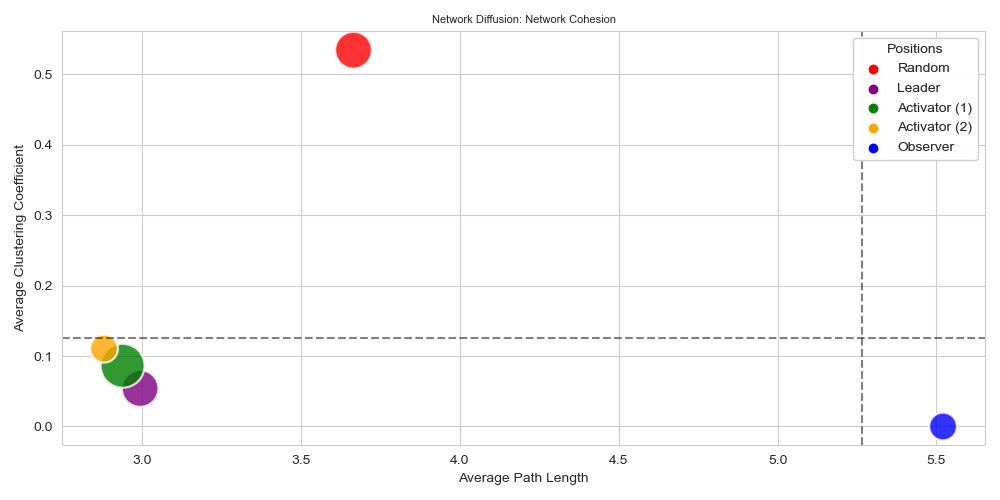

In [7]:
#COMMUNITY-ROLE DESCRIPTION
n=5

'''seed_dict = {"Random": r_lst, "Leader": l_lst, "Activator (1)": a_lst_1, "Activator (2)": a_lst_2, "Observer": o_lst}
tot_com = len(set((df_vcomm_1['community_op']).to_list()))
#print(tot_com)
tot_nodes = G_dn1.number_of_nodes()
#print(tot_nodes)
avg_deg = np.mean((df_vcomm_1['strength']).to_list())
#print(avg_deg)

mean_pth = G_ig.average_path_length(directed=True)
mean_cls = G_ig.transitivity_avglocal_undirected()

dict_com={}
com_stat_lst = []
avg_com_stat_lst = []
for k,s in seed_dict.items():
    com_lst = set((df_vcomm_1['community_op'].loc[df_vcomm_1['id_'].isin(s)]).to_list())
    #print(len(set(com_lst)))
    mem_lst = (df_vcomm_1['id_'].loc[df_vcomm_1['community_op'].isin(com_lst)]).to_list()
    #print(len(mem_lst))
    
    s_id = [G_ig.vs.find(id=i).index for i in s]
    #print(k, s_id)
    #[1757, 1686, 106, 1764, 1475, 1378] 
    #path     
    pth_lst = G_ig.shortest_paths(source=s_id, weights='weight', mode='all')
    cls_lst = G_ig.transitivity_local_undirected(vertices=s_id, weights='weight', mode='zero')
    #print(cls_lst)
    #print(pth_lst)
       
    siz_c_lst = []
    den_c_lst = []
    pth_c_lst = []
    deg_c_lst = []
    cls_c_lst = []
    avg_deg_c_lst = []

    for com in com_lst:
        df_vc = df_vcomm_1.loc[df_vcomm_1["community_op"]==com]
        df_ec = df_ecomm_1.loc[df_ecomm_1["community_op"]==com]
        G_ig_c=ig.Graph.DictList(df_vc.to_dict('records'), df_ec.to_dict('records'), directed=False, vertex_name_attr='id_', edge_foreign_keys=('source_', 'target_'))
        
        #size
        siz_c = G_ig_c.vcount()
        siz_c_lst.append(siz_c)  
        #density
        den_c = G_ig_c.density()
        den_c_lst.append(den_c)
        #path
        pth_c = G_ig_c.average_path_length(directed=True)
        pth_c_lst.append(pth_c)  
        #print(pth_c)
        #clustering
        cls_c = G_ig_c.transitivity_avglocal_undirected()
        cls_c_lst.append(cls_c)
        # degree
        deg_c = G_ig_c.strength(weights='weight',mode='all')
        avg_deg_c = np.mean(deg_c)
        avg_deg_c_lst.append(avg_deg_c)
        #print(siz_c_lst)
        #print(den_c_lst)
        #print(deg_c_lst)
        
        siz_k = siz_c/tot_nodes 
        com_stat = (k,siz_k,den_c,cls_c)
        com_stat_lst.append(com_stat)
        
    tot_com_k = len(set(com_lst))
    tot_siz_k = np.sum(siz_c_lst)
    avg_den_k = np.mean(den_c_lst)
    avg_pth_k = np.mean(pth_lst)
    avg_deg_k = np.mean(avg_deg_c_lst)
    avg_cls_k = np.mean(cls_lst)
    
   
    avg_com_stat = (k,tot_com_k,tot_siz_k,avg_den_k,avg_pth_k,avg_cls_k)
    print(avg_com_stat)
    avg_com_stat_lst.append(avg_com_stat)
    
    
    #dict_com[k]=com_stat_lst
#print(dict_com)
#df_comk = pd.DataFrame(com_stat_lst, columns=['Positions','mem','den','cls'])
df_comk = pd.DataFrame(avg_com_stat_lst, columns=['Positions','tot_com','tot_mem','avg_den','avg_pth','avg_cls'])
#print(df_comk)


plt.rcParams["figure.figsize"]=[10,5]
c_role=['red','purple', 'green','orange','blue']
sns.set_palette(c_role)
sns.set_style("whitegrid")
#ax=sns.scatterplot(data=df_comk, y="cls", x="mem", hue="Positions", alpha=0.8)
ax=sns.scatterplot(data=df_comk, y="avg_cls", x="avg_pth", size="tot_com", hue="Positions", alpha=0.8, sizes=(400,1000))
x_line = plt.axvline(mean_pth, linestyle='--', color = 'black', alpha=0.5)
y_line = plt.axhline(mean_cls, linestyle='--', color = 'black', alpha=0.5)
plt.title('Network Diffusion: Network Cohesion', fontsize=8)
plt.xlabel('Average Path Length')
plt.ylabel('Average Clustering Coefficient')
##legends
h,l = ax.get_legend_handles_labels()
col_lgd = plt.legend(h[1:6], l[1:6], loc='upper right', title='Positions')
plt.gca().add_artist(col_lgd)
plt.savefig("images_d_0/putsafirst_diff_("+str(n)+")_3a.png")
plt.show()'''

'''
Random [4908, 7264, 1751, 870, 500, 7329]
Leader [283, 43, 271, 110, 620, 31]
Activator (1) [107, 4, 57, 2651, 146, 199]
Activator (2) [57, 2, 118, 300, 107, 500]
Observer [7303, 7319, 7243, 7334]

('Random', 5, 3516, 0.0030573586089762865, 3.664782189499518, 0.0)
('Leader', 5, 2715, 0.0033498856945389927, 2.993075642036988, 0.0)
('Activator (1)', 6, 3699, 0.003482838016100802, 2.9379875536856868, 0.0)
('Activator (2)', 4, 2846, 0.0030884877949706405, 2.8794153738276798, 0.0)
('Observer', 4, 2671, 0.0038921332819009443, 5.520773073889035, 0.0)
'''
'''('Random', 5, 3516, 0.0030573586089762865, 4.021182538537877, 0.0)
('Leader', 5, 2715, 0.0033498856945389927, 4.134672296899103, 0.0)
('Activator (1)', 6, 3699, 0.003482838016100802, 4.304646289096791, 0.0)
('Activator (2)', 4, 2846, 0.0030884877949706405, 4.10661853980902, 0.0)
('Observer', 4, 2671, 0.0038921332819009443, 4.501533499814849, 0.0)'''

'''('Random', 5, 3516, 0.0030573586089762865, 3.664782189499518, 0.5343517182364471)
('Leader', 5, 2715, 0.0033498856945389927, 2.993075642036988, 0.05396044784650886)
('Activator (1)', 6, 3699, 0.003482838016100802, 2.9379875536856868, 0.0861962970560861)
('Activator (2)', 4, 2846, 0.0030884877949706405, 2.8794153738276798, 0.11054901156805685)
('Observer', 4, 2671, 0.0038921332819009443, 5.520773073889035, 0.0)'''

#----
plt.close()
#---
Image(filename="images_d_0/putsafirst_diff_(5)_3a.png",  width = "650")
#5 5 6 4 4 

#### 1.2. Diffusion In and Out Community


To estimate the daily spread of an infection, I simulate the diffusion process of each initial seed in each role and compare the ratio of infected nodes within community and outside community across early and late-stage diffusion. For this network, early stage refers to all infections (adoptions) before 5 October 2020 and late stage are all infections (adoptions) up to to 31 May 2021. Again, to control for low modularity obtained from the partition, I focus my analysis on the ratio of all infected nodes both within and outside community. 

In [8]:
##COMMUNITY DIFFUSION
#PRE-PEAK PERIOD
#output_notebook()
# Model selection - ProfileThresholdModel
#model_pt = ep.ProfileThresholdModel(G_nx)
#print(len(n1_lst))
'''val_lst=[]
val_lst_x=[]
seed2_dict = {"Random": r2_lst, "Leader": l2_lst, "Activator (1)": a2_lst_1, "Activator (2)": a2_lst_2, "Observer": o2_lst}
for k,s in seed2_dict.items():
    #print(k)

    for r_iter in range(0,100):
        #print(r_iter)
        #print(s)
        com_lst = (df_vcomm_1['community_op'].loc[df_vcomm_1['id_'].isin(s)]).to_list()
        #print(com_lst)
        #print(set(com_lst))
        mem_lst = (df_vcomm_1['id_'].loc[df_vcomm_1['community_op'].isin(com_lst)]).to_list()
        #print(mem_lst)

        model = dm.DynProfileThresholdModel(G_dn2)

        # Model Configuration
        config = mc.Configuration()
        #config.add_model_parameter('percentage_infected', 0.01)
        config.add_model_parameter('adopter_rate', adopt)
        config.add_model_parameter('percentage_blocked', block)
        config.add_model_initial_configuration('Infected', s)

        # Setting node parameters
        for i in G_dn2.nodes():
            config.add_node_configuration("threshold", i, threshold)
            config.add_node_configuration("profile", i, profile)
        model.set_initial_status(config)

        # Simulation execution
        iterations = model.execute_snapshots()
        #iterations = model_pt.iteration_bunch(n)
        trends = model.build_trends(iterations)
        #print(len(iterations))

        in_com_prev=0
        out_com_prev=0
        inf_prev = 0
        #print(len(iterations))
        for it in iterations:
            t=it['iteration']
            #print("iter:", it['iteration'])
            infected = len([v for k,v in it['status'].items() if v==1])
            in_com_lst = [id_key for id_key, val in it['status'].items() if id_key in mem_lst and val==1] 
            out_com_lst = [id_key for id_key, val in it['status'].items() if id_key not in mem_lst and val==1] 
            
            inf_lst = [id_key for id_key, val in it['status'].items() if val==1] 

            if infected > 0:
                in_com = (len(in_com_lst)/infected)+in_com_prev
                out_com = (len(out_com_lst)/infected)+out_com_prev
                inf = (len(inf_lst)/infected)+inf_prev
                #print(in_com,out_com)
            else:
                in_com = in_com_prev
                out_com = out_com_prev 
                inf = inf_prev
                #print(in_com,out_com)
                
            in_com_prev = in_com
            out_com_prev = out_com
            inf_prev = inf

            tmp = (k,t,in_com,out_com, inf)
            val_lst.append(tmp) 
            #print(val_lst) 
            
            if t==len(iterations)-1:
                val_lst_x.append(tmp)
                

df_c_2 = pd.DataFrame(val_lst, columns=['Positions','Iterations','in_com','out_com','inf'])
#print(df_c)
df_c_x_2 = pd.DataFrame(val_lst_x, columns=['Positions','Iterations','in_com','out_com','inf'])
#print(df_c_x)'''

#---- 
plt.close()
#----  

In [9]:
print("--------" + "\n" + '\033[1m' +"Period: "+ '\033[0m' + '1 September 2020 - 4 October 2020' + "\n")
print('\033[1m' +"Parameters:"+ '\033[0m')
print("a. "+ str(no_leader2) + " Randoms Infected")
print("b. "+ str(no_leader2) + " Leaders Infected") 
print("c. "+ str(no_activator2_1) +  " Activators (1) Infected") 
print("d. "+ str(no_activator2_2) + " Activators (2) Infected")
print("e. "+ str(no_observer2) + " Observers Infected")

--------
Period: 1 September 2020 - 4 October 2020

Parameters:
a. 2 Randoms Infected
b. 2 Leaders Infected
c. 2 Activators (1) Infected
d. 2 Activators (2) Infected
e. 2 Observers Infected


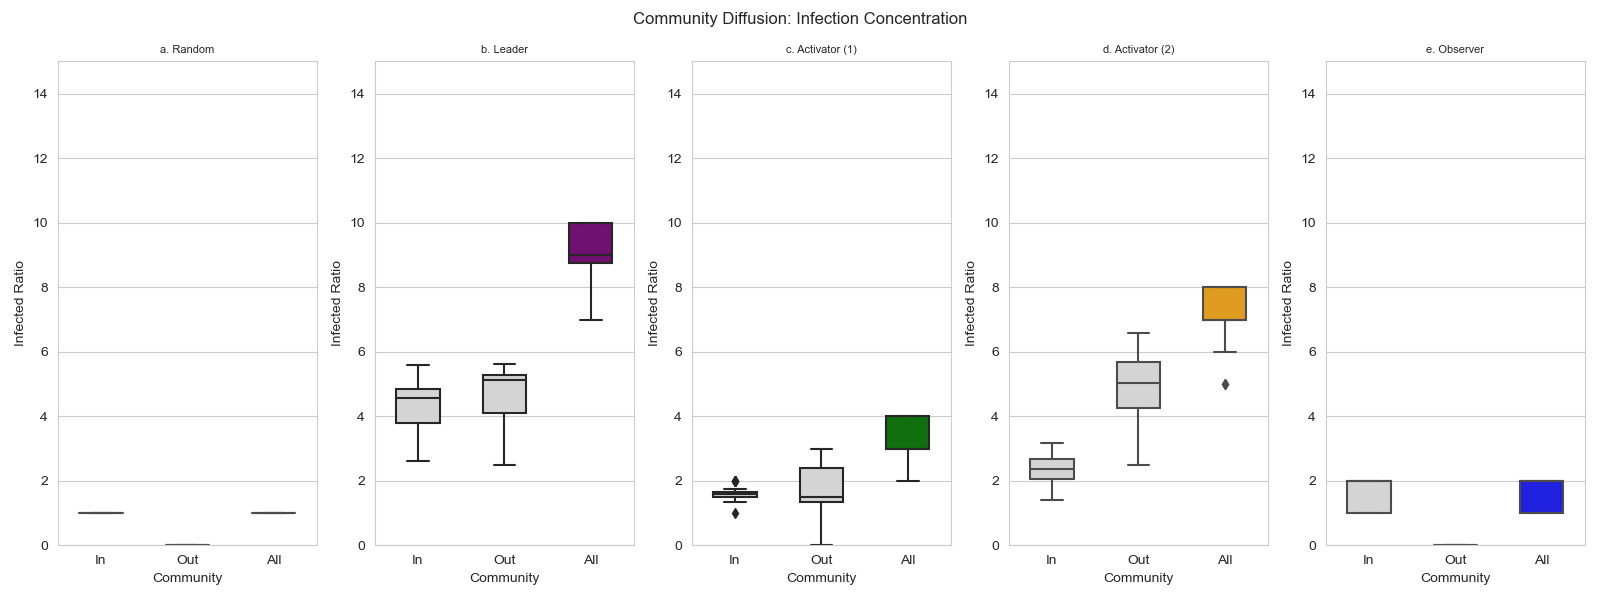

In [10]:
#Within/Between Diffusion Plot - PRE
'''c_crole=[['#D4D4D4','#D4D4D4', 'red'], ['#D4D4D4','#D4D4D4','purple'], ['#D4D4D4','#D4D4D4','green'],['#D4D4D4','#D4D4D4','orange'],['#D4D4D4','#D4D4D4','blue']]
r_role = ["a. Random","b. Leader","c. Activator (1)","d. Activator (2)","e. Observer"]
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"]=[16,6]
df_col = df_c_x_2.rename(columns={'in_com':'In', 'out_com':'Out', 'inf':'All'})
max_y = max(df_col['In'].max(),df_col['Out'].max(),df_col['All'].max())
min_y = min(df_col['In'].min(),df_col['Out'].min(),df_col['All'].min())
#print(df_c_x)
df_c_long = pd.melt(df_col, id_vars='Positions', value_vars=['In','Out', 'All'])
for i,r in enumerate(seed_dict.keys()):
    sns.set_palette(c_crole[i])
    df_c_long_x = df_c_long.loc[df_c_long['Positions']==r]
    plt.subplot(1,5,i+1)
    sns.boxplot(data=df_c_long_x, x="variable", y='value', width=0.5)
    plt.title(r_role[i], fontsize=8)
    plt.ylim(0,max_y+5)
    plt.ylabel('Infected Ratio')
    plt.xlabel('Community')
plt.suptitle('Community Diffusion: Infection Concentration', fontsize=12)    
plt.savefig("images_d_0/putsafirst_diff_("+str(n)+")_4a.png")
plt.show()'''

#---- 
plt.close()
#----    
Image(filename="images_d_0/putsafirst_diff_(4)_4a.png",  width = "850")

In [11]:
##COMMUNITY DIFFUSION
#FULL PERIOD
#output_notebook()
# Model selection - ProfileThresholdModel
#model_pt = ep.ProfileThresholdModel(G_nx)
'''n1_lst = G_dn1.nodes()
#print(len(n1_lst))
val_lst=[]
val_lst_x=[]
#seed_dict = {1: l_lst, 2: a_lst, 3: d_lst, 4: o_lst}
for k,s in seed_dict.items():
    #print(k)

    for r_iter in range(0,20):
        #print(r_iter)
        #print(s)
        com_lst = (df_vcomm_1['community_op'].loc[df_vcomm_1['id_'].isin(s)]).to_list()
        #print(com_lst)
        #print(set(com_lst))
        mem_lst = (df_vcomm_1['id_'].loc[df_vcomm_1['community_op'].isin(com_lst)]).to_list()
        #print(mem_lst)

        model = dm.DynProfileThresholdModel(G_dn1)

        # Model Configuration
        config = mc.Configuration()
        #config.add_model_parameter('percentage_infected', 0.01)
        config.add_model_parameter('adopter_rate', adopt)
        config.add_model_parameter('percentage_blocked', block)
        config.add_model_initial_configuration('Infected', s)

        # Setting node parameters
        for i in G_dn1.nodes():
            config.add_node_configuration("threshold", i, threshold)
            config.add_node_configuration("profile", i, profile)
        model.set_initial_status(config)

        # Simulation execution
        iterations = model.execute_snapshots()
        #iterations = model_pt.iteration_bunch(n)
        trends = model.build_trends(iterations)
        #print(len(iterations))

        in_com_prev=0
        out_com_prev=0
        inf_prev=0
        #print(len(iterations))
        for it in iterations:
            t=it['iteration']
            #print("iter:", it['iteration'])
            infected = len([v for k,v in it['status'].items() if v==1])
            in_com_lst = [id_key for id_key, val in it['status'].items() if id_key in mem_lst and val==1] 
            out_com_lst = [id_key for id_key, val in it['status'].items() if id_key not in mem_lst and val==1] 
            inf_lst = [id_key for id_key, val in it['status'].items() if  val==1] 

            if infected > 0:
                in_com = (len(in_com_lst)/infected)+in_com_prev
                out_com = (len(out_com_lst)/infected)+out_com_prev
                inf = (len(inf_lst)/infected)+inf_prev
                #print(in_com,out_com)
            else:
                in_com = in_com_prev
                out_com = out_com_prev 
                inf = inf_prev 
                #print(in_com,out_com)
                
            in_com_prev = in_com
            out_com_prev = out_com
            inf_prev = inf

            tmp = (k,t,in_com,out_com,inf)
            val_lst.append(tmp) 
            #print(val_lst) 
            
            if t==len(iterations)-1:
                val_lst_x.append(tmp)
                

df_c = pd.DataFrame(val_lst, columns=['Positions','Iterations','in_com','out_com','inf'])
#print(df_c)
df_c_x = pd.DataFrame(val_lst_x, columns=['Positions','Iterations','in_com','out_com','inf'])
#print(df_c_x)'''

#---- 
plt.close()
#---- 

In [12]:
print("--------" + "\n" + '\033[1m' +"Period: "+ '\033[0m' + '1 September 2020 - 31 May 2021' + "\n")
print('\033[1m' +"Parameters:"+ '\033[0m')
print("a. "+ str(no_leader) + " Randoms Infected")
print("b. "+ str(no_leader) + " Leaders Infected") 
print("c. "+ str(no_activator_1) +  " Activators (1) Infected") 
print("d. "+ str(no_activator_2) + " Activators (2) Infected")
print("e. "+ str(no_observer) + " Observers Infected")

--------
Period: 1 September 2020 - 31 May 2021

Parameters:
a. 6 Randoms Infected
b. 6 Leaders Infected
c. 6 Activators (1) Infected
d. 6 Activators (2) Infected
e. 4 Observers Infected


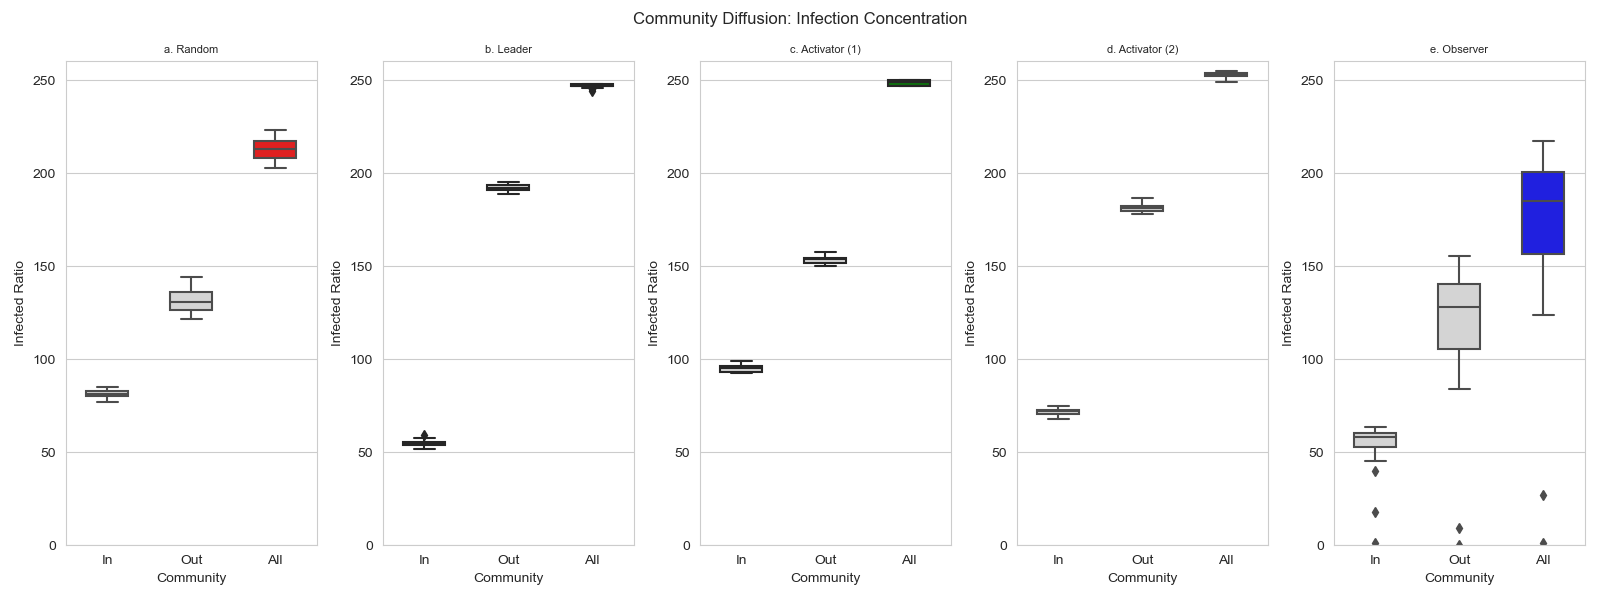

In [13]:
#### Within/Between Diffusion Plot - FULL
'''sns.set_style("whitegrid")
plt.rcParams["figure.figsize"]=[16,6]
df_col = df_c_x.rename(columns={'in_com':'In', 'out_com':'Out', 'inf':'All'})
max_y = max(df_col['In'].max(),df_col['Out'].max(),df_col['All'].max())
min_y = min(df_col['In'].min(),df_col['Out'].min(),df_col['All'].min())
#print(df_c_x)
df_c_long = pd.melt(df_col, id_vars='Positions', value_vars=['In','Out', 'All'])
for i,r in enumerate(seed_dict.keys()):
    sns.set_palette(c_crole[i])
    df_c_long_x = df_c_long.loc[df_c_long['Positions']==r]
    plt.subplot(1,5,i+1)
    sns.boxplot(data=df_c_long_x, x="variable", y='value', width=0.5)
    plt.title(r_role[i], fontsize=8)
    plt.ylim(0,max_y+5)
    plt.ylabel('Infected Ratio')
    plt.xlabel('Community')
plt.suptitle('Community Diffusion: Infection Concentration', fontsize=12)    
plt.savefig("images_d_0/putsafirst_diff_("+str(n)+")_4b.png")
plt.show()
'''
#---- 
plt.close()
#----  
Image(filename="images_d_0/putsafirst_diff_(4)_4b.png",  width = "850")

In [14]:
##Role Model
#output_notebook()
# Model selection - ProfileThresholdModel
#model_pt = ep.ProfileThresholdModel(G_nx)
'''seed_dict = {0:r_lst, 1: l_lst, 2: a_lst_1, 3: a_lst_2, 4: o_lst}
for k,s in seed_dict.items():
    model = dm.DynProfileThresholdModel(G_dn)

    # Model Configuration
    config = mc.Configuration()
    #config.add_model_parameter('percentage_infected', 0.01)
    config.add_model_parameter('adopter_rate', adopt)
    config.add_model_parameter('percentage_blocked', block)
    config.add_model_initial_configuration('Infected', s)

    # Setting node parameters
    for i in G_dn.nodes():
        config.add_node_configuration("threshold", i, threshold)
        config.add_node_configuration("profile", i, profile)
    model.set_initial_status(config)

    # Simulation execution
    iterations = model.execute_snapshots()
    #iterations = model_pt.iteration_bunch(n)
    trends = model.build_trends(iterations)
    
    # Visualise Diffusion
    viz_t = DiffusionTrend(model, trends)
    viz_t.plot("images_d_0/"+ str(k) +"putsafirst_diff_"+ str(n) +"_1a.svg", statuses=["Infected"], percentile=90)

    viz_p = DiffusionPrevalence(model, trends)
    viz_p.plot("images_d_0/"+ str(k) +"putsafirst_diff_"+ str(n) +"_2a.svg")
    #show(l)

    #Export
    #iterations.write_snapshots()
    dict_st={}
    id_st={}
    #print(iterations)

    for it in iterations:
        #print(it['iteration'])
        id_st = {innerKey:values for innerKey, values in it['status'].items()} 
        dict_st[it['iteration']] = id_st            
        #print(dict_st)
    df_st = pd.DataFrame(dict_st)
    #print(df_st)

    i=0
    u=301
    v=len(iterations)
    df_st['infect_'+str(k)] = df_st[i]
    df_st['iter_'+ str(k)+'_'+str(i+1)] = df_st.iloc[:, i+1:u].sum(axis=1, skipna=True) - df_st[i]
    for i in range(2,4):
        #print(i)
        df_st['iter_'+str(k)+'_'+str(i)] = df_st.iloc[:, u:u+100].sum(axis=1, skipna=True) - df_st.iloc[:, 0:u].sum(axis=1, skipna=True)
        i+=1
        u+=100
    df_st['end_'+str(k)] = df_st.iloc[:, v:v+1].sum(axis=1, skipna=True) - df_st.iloc[:, 0:v].sum(axis=1, skipna=True)

    df_st = df_st.loc[:, 'infect_'+ str(k):'end_'+ str(k)].reset_index(drop=False)
    #print(df_st)
    df_st.to_csv("putsafirst_diff_"+ str(k)+".csv", sep=";",encoding='utf-8',  index=False)
    
'''    
#----

plt.close()
#----

----------------------------------------------------------
#### 2. POSITIONAL DIFFUSION 


To simulate the rate and extent of possible diffusion in peak discourse, I trace and plot multiple diffusion trends by assigning specific users from each role as initial seeds. I also visualise a snapshot graph showing the infection rate for each simulation from interactions on 5 October 2020. A community layout is applied to the snapshot graph so that users are mapped within their detected community.


#### 2.1. Random Seed Infection

In [15]:
print("--------" + "\n" + '\033[1m' +"Period: "+ '\033[0m' + '5 October 2020 00:00:00 - 5 October 2020 23:59:59' + "\n")
print('\033[1m' +"Parameters: "+ '\033[0m' + str(format(leader*100,'.2f')) + "%" + " Infected, " + str(profile*100) + "% Profile, " + str(threshold*100) + "% Threshold, " + str(block*100) + "% Blocked." + "\n")
print('\033[1m' +"Start: "+ '\033[0m' + str(no_leader) + ' Randoms Infected' + "\n")
print('\033[1m' +"End: "+ '\033[0m' + '169 Users Infected')

--------
Period: 5 October 2020 00:00:00 - 5 October 2020 23:59:59

Parameters: 1.36% Infected, 25.0% Profile, 60.0% Threshold, 0% Blocked.

Start: 6 Randoms Infected

End: 169 Users Infected


--------
Random Diffusion Trend



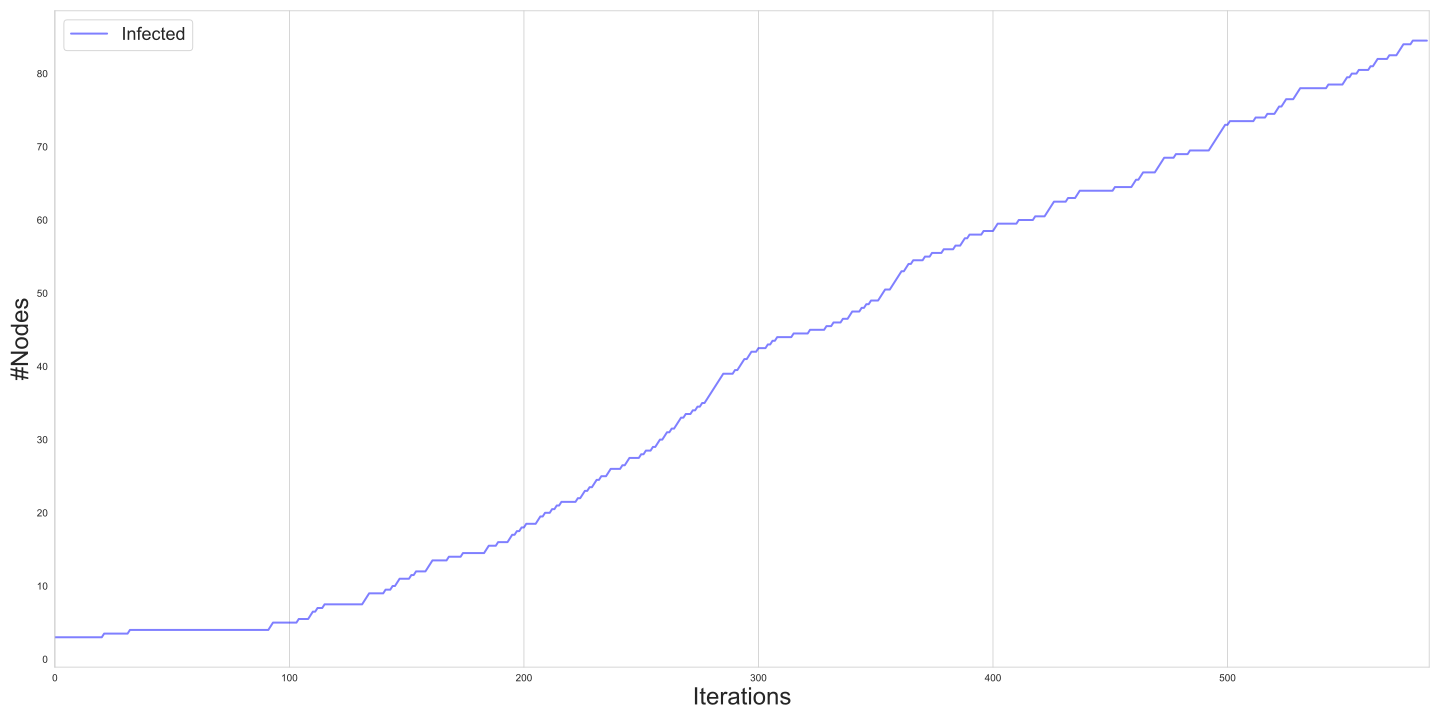

In [30]:
###
print("--------" + "\n" + '\033[1m' +"Random Diffusion Trend"+ '\033[0m' + "\n")
display(SVG(filename="images_d_0\\0putsafirst_diff_0_1a.svg"))

--------
Random Diffusion Infected



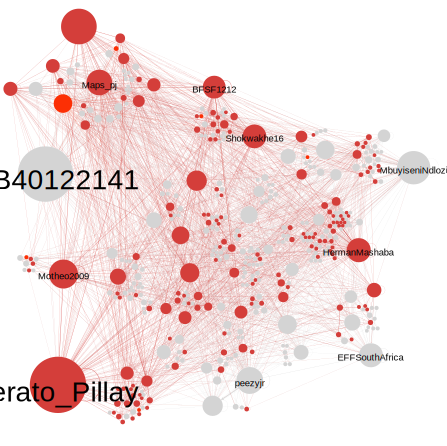

In [41]:
#
print("--------" + "\n" + '\033[1m' +"Random Diffusion Infected"+ '\033[0m' + "\n")
display(SVG(filename="images_d_0\\0_putsafirst_diff_r.svg"))

#### 2.2. Leader Seed Infection

In [18]:
print("--------" + "\n" + '\033[1m' +"Period: "+ '\033[0m' + '5 October 2020 00:00:00 - 5 October 2020 23:59:59' + "\n")
print('\033[1m' +"Parameters: "+ '\033[0m' + str(format(leader*100,'.2f')) + "%" + " Infected, " + str(profile*100) + "% Profile, " + str(threshold*100) + "% Threshold, " + str(block*100) + "% Blocked." + "\n")
print('\033[1m' +"Start: "+ '\033[0m' + str(no_leader) + ' Leaders Infected' + "\n")
print('\033[1m' +"End: "+ '\033[0m' + '185 Users Infected')

--------
Period: 5 October 2020 00:00:00 - 5 October 2020 23:59:59

Parameters: 1.36% Infected, 25.0% Profile, 60.0% Threshold, 0% Blocked.

Start: 6 Leaders Infected

End: 185 Users Infected


--------
Leader Diffusion Trend



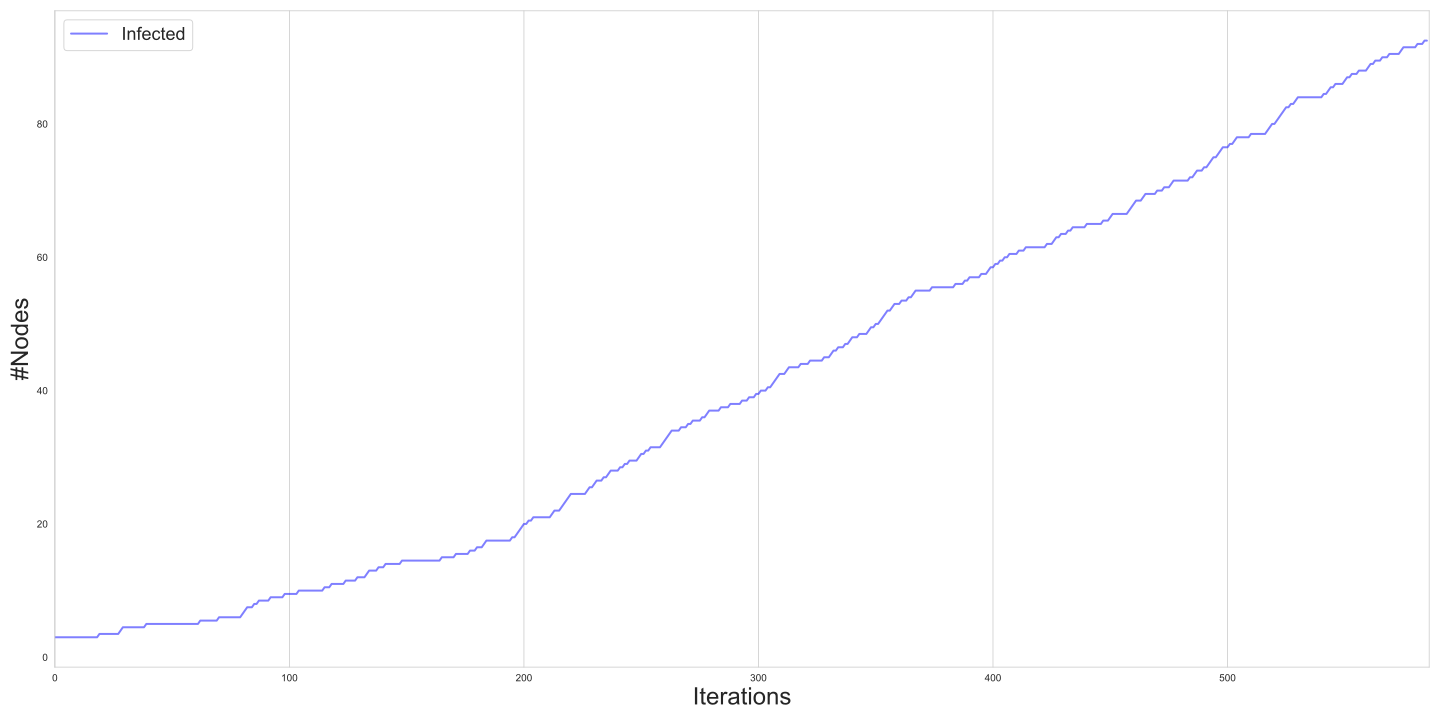

In [39]:
###
print("--------" + "\n" + '\033[1m' +"Leader Diffusion Trend"+ '\033[0m' + "\n")
display(SVG(filename="images_d_0\\1putsafirst_diff_0_1a.svg"))

--------
Leader Diffusion Infected



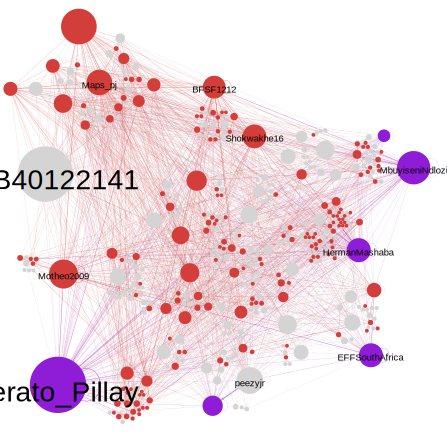

In [42]:
#
print("--------" + "\n" + '\033[1m' +"Leader Diffusion Infected"+ '\033[0m' + "\n")
display(SVG(filename="images_d_0\\1_putsafirst_diff_l.svg"))

#### 2.3. Activator (1) Seed Infection

In [21]:
print("--------" + "\n" + '\033[1m' +"Period: "+ '\033[0m' + '5 October 2020 00:00:00 - 5 October 2020 23:59:59' + "\n")
print('\033[1m' +"Parameters: "+ '\033[0m' + str(format(activator_1*100,'.2f')) + "%" + " Infected, " + str(profile*100) + "% Profile, " + str(threshold*100) + "% Threshold, " + str(block*100) + "% Blocked." + "\n")
print('\033[1m' +"Start: "+ '\033[0m' + str(no_activator_1) + ' Activators (1) Infected' + "\n")
print('\033[1m' +"End: "+ '\033[0m' + '102 Users Infected')

--------
Period: 5 October 2020 00:00:00 - 5 October 2020 23:59:59

Parameters: 1.36% Infected, 25.0% Profile, 60.0% Threshold, 0% Blocked.

Start: 6 Activators (1) Infected

End: 102 Users Infected


--------
Activator (1) Diffusion Trend



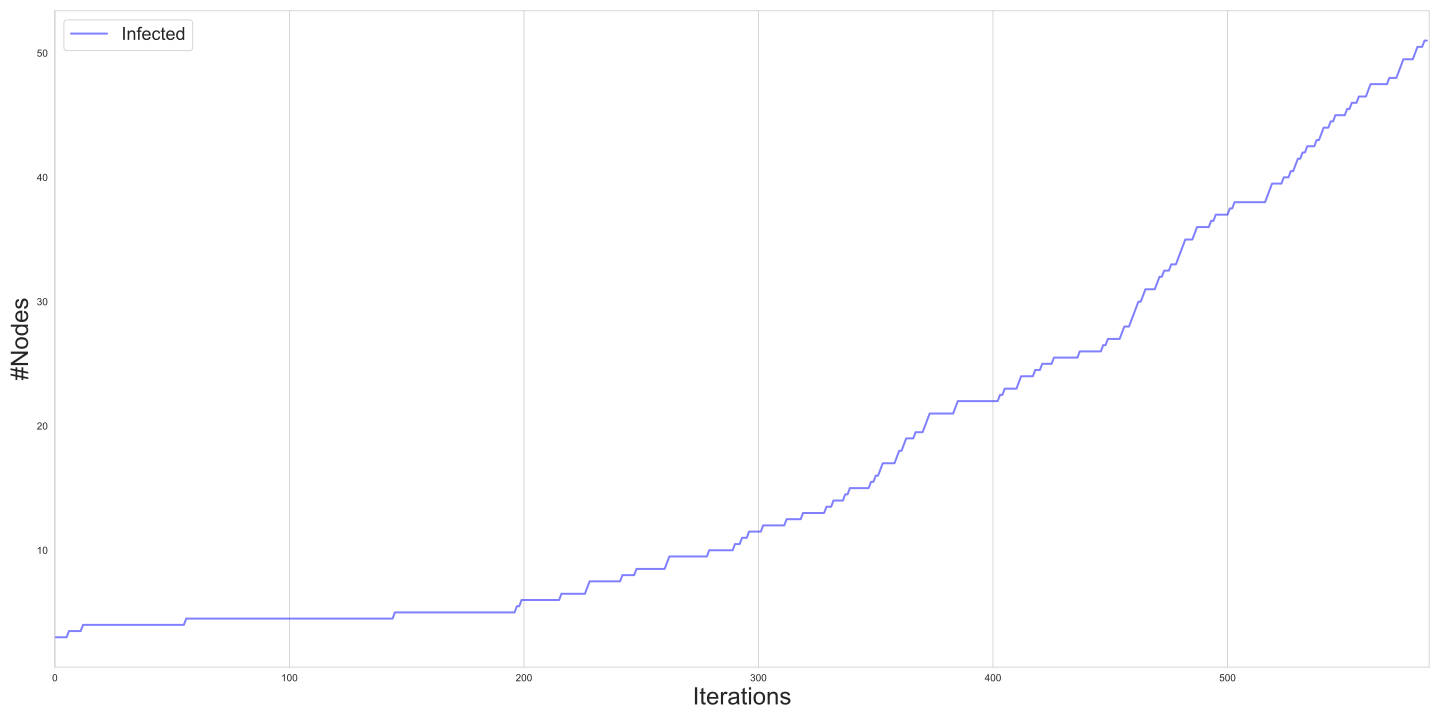

In [32]:
###
print("--------" + "\n" + '\033[1m' +"Activator (1) Diffusion Trend"+ '\033[0m' + "\n")
display(SVG(filename="images_d_0\\2putsafirst_diff_0_1a.svg"))

--------
Activator (1) Diffusion Infected



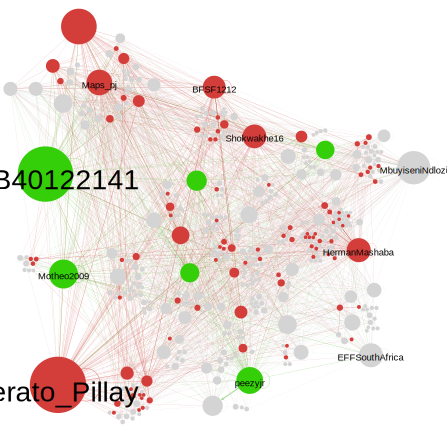

In [38]:
#
print("--------" + "\n" + '\033[1m' +"Activator (1) Diffusion Infected"+ '\033[0m' + "\n")
display(SVG(filename="images_d_0\\2_putsafirst_diff_a.svg"))

#### 2.4. Activator (2) Seed Infection

In [24]:
print("--------" + "\n" + '\033[1m' +"Period: "+ '\033[0m' + '5 October 2020 00:00:00 - 5 October 2020 23:59:59' + "\n")
print('\033[1m' +"Parameters: "+ '\033[0m' + str(format(activator_2*100,'.2f')) + "%" + " Infected, " + str(profile*100) + "% Profile, " + str(threshold*100) + "% Threshold, " + str(block*100) + "% Blocked." + "\n")
print('\033[1m' +"Start: "+ '\033[0m' + str(no_activator_2) + ' Activators (2) Infected' + "\n")
print('\033[1m' +"End: "+ '\033[0m' + '168 Users Infected')

--------
Period: 5 October 2020 00:00:00 - 5 October 2020 23:59:59

Parameters: 1.36% Infected, 25.0% Profile, 60.0% Threshold, 0% Blocked.

Start: 6 Activators (2) Infected

End: 168 Users Infected


--------
Activator (2) Diffusion Trend



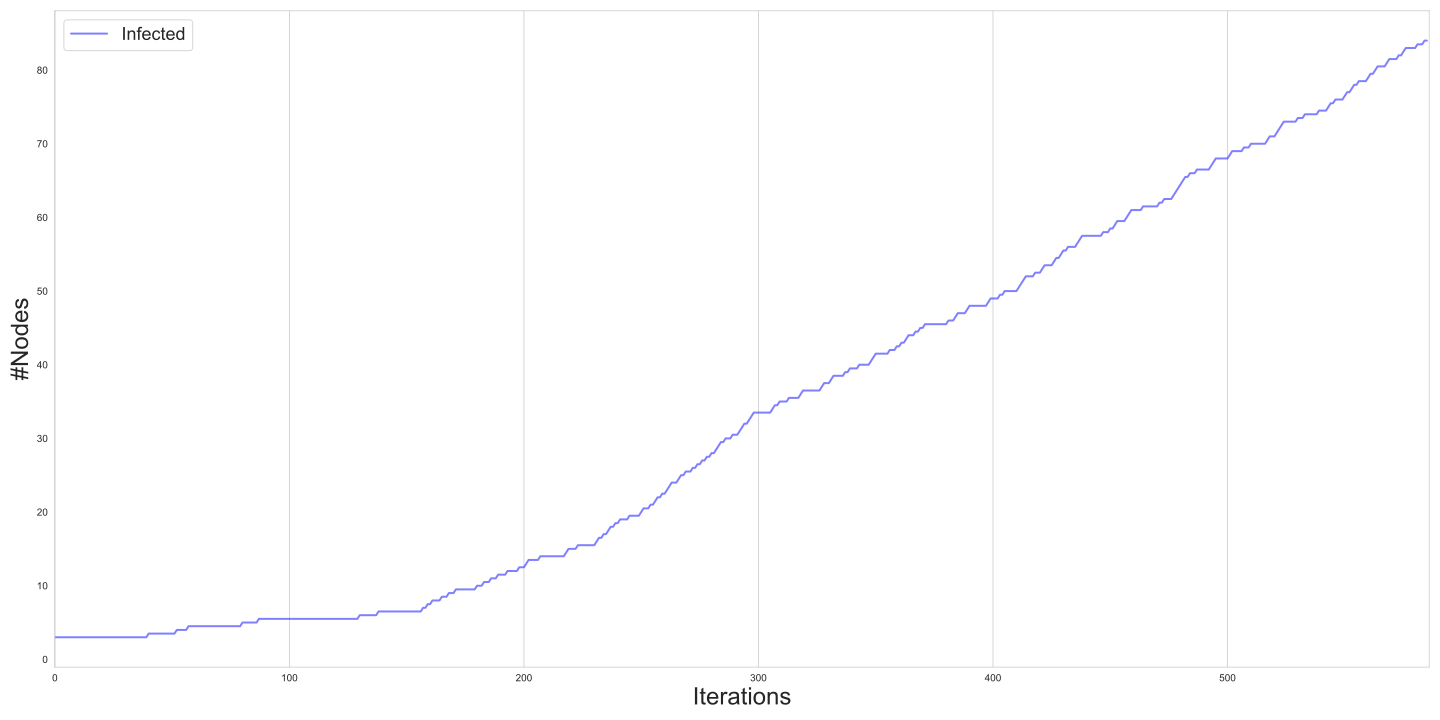

In [44]:
###
print("--------" + "\n" + '\033[1m' +"Activator (2) Diffusion Trend"+ '\033[0m' + "\n")
display(SVG(filename="images_d_0\\3putsafirst_diff_0_1a.svg"))

--------
Activator (2) Diffusion Infected



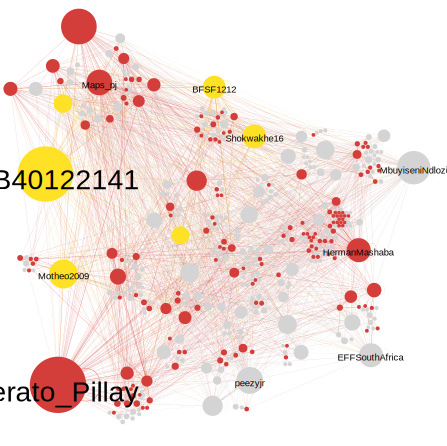

In [36]:
#
print("--------" + "\n" + '\033[1m' +"Activator (2) Diffusion Infected"+ '\033[0m' + "\n")
display(SVG(filename="images_d_0\\3_putsafirst_diff_d.svg"))

#### 2.5. Observer Seed Infection

In [27]:
print("--------" + "\n" + '\033[1m' +"Period: "+ '\033[0m' + '5 October 2020 00:00:00 - 5 October 2020 23:59:59' + "\n")
print('\033[1m' +"Parameters: "+ '\033[0m' + str(format(observer*100,'.2f')) + "% Infected, " + str(profile*100) + "% Profile, " + str(threshold*100) + "% Threshold, " + str(block*100) + "% Blocked." + "\n")
print('\033[1m' +"Start: "+ '\033[0m' + str(no_observer) + ' Observers Infected' + "\n")
print('\033[1m' +"End: "+ '\033[0m' + '8 Users Infected')

--------
Period: 5 October 2020 00:00:00 - 5 October 2020 23:59:59

Parameters: 0.91% Infected, 25.0% Profile, 60.0% Threshold, 0% Blocked.

Start: 4 Observers Infected

End: 8 Users Infected


--------
Observer Diffusion Trend



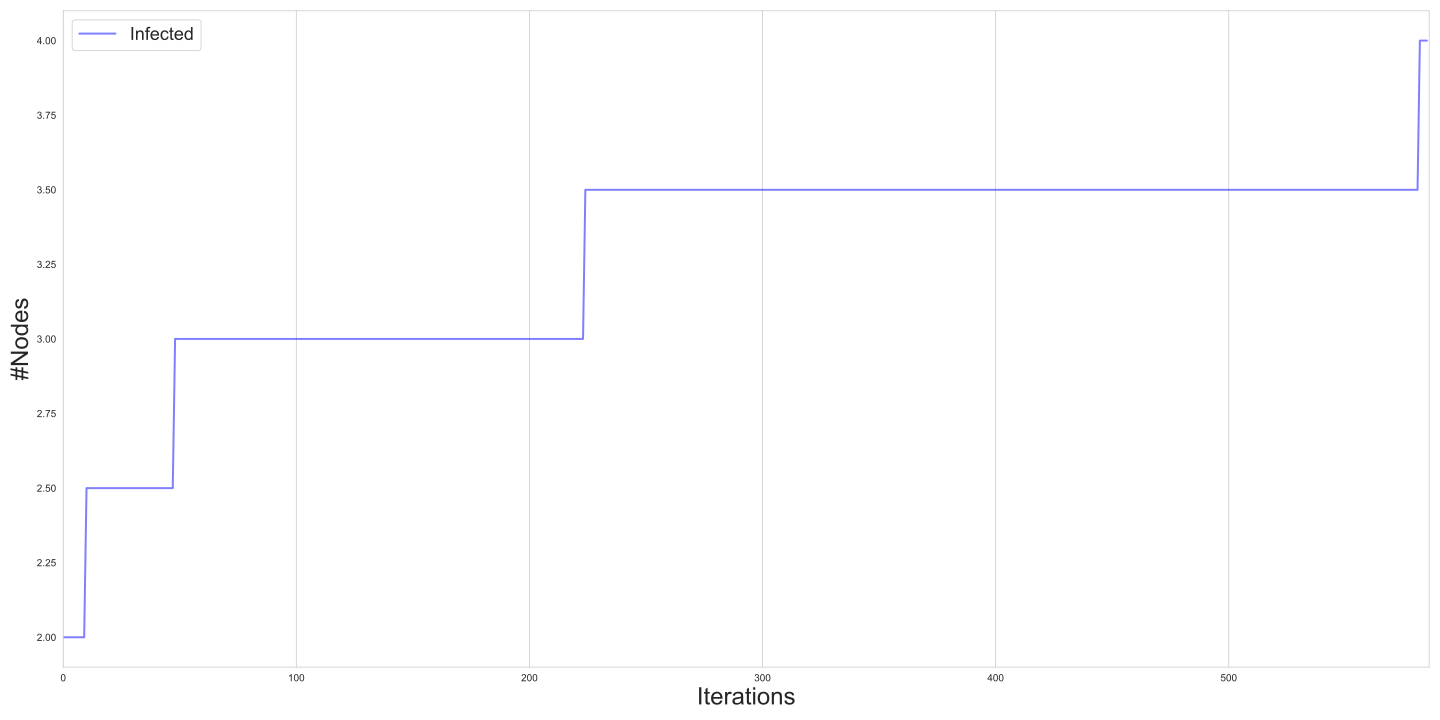

In [34]:
###
print("--------" + "\n" + '\033[1m' +"Observer Diffusion Trend"+ '\033[0m' + "\n")
display(SVG(filename="images_d_0\\4putsafirst_diff_0_1a.svg"))

--------
Observer Diffusion Infected



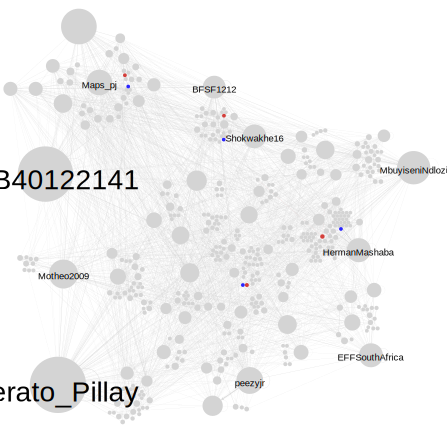

In [35]:
#
print("--------" + "\n" + '\033[1m' +"Observer Diffusion Infected"+ '\033[0m' + "\n")
display(SVG(filename="images_d_0\\4_putsafirst_diff_o.svg"))

----------------------------------------------------------------
#### 3. SUMMARY 



In this section, I simulate multiple diffusion processes and make inferences about the people, positions and groups that have the potential to effectively spread information and incite widespread discourse in the #PutSAFirst twitter reply network.    

To explore the link between community cohesion and diffusion, I map the average path length and clustering coefficient for initial seeds in each role. The cohesion plot shows that *Observer* seeds have the highest average path length, while *Activator (2)*, *Activator (1)*, and *Leader* seeds have the lowest. *Observer* seeds are found to have the lowest clustering coefficient, and *Random* seeds to have the highest. Assuming redundant ties are reinforcing, *Random* seeds are best placed to outperform.

The diffusion performance of seeds in each role are represented by boxplots. I find *Leader* seeds to have the advantage in early-stages, and *Activator (2)* seeds in late-stages, albeit by a marginal difference. In fact, the late-stage results for *Leader*, *Activator (1)*, and Activator (2) seeds are very similar, much like their cohesion attributes. *Random* and *Observer* seed performance are not too far behind either. The diffusion performance in this network does not appear to be driven by the type of user or role initiating the spread. In other words, unlike the other networks, I fail to find a significant relationship between position and diffusion. This could be attributed to the clustering coefficient measure described in part I. This network has a substantially higher clustering coefficient than would be expected in a random network (163.7x higher compared to 20.9x higher and 25.1x higher found in the #Senekal and #Brackenfell networks, respectively). Inline with most predictions, this confirms that redundant ties act as a social reinforcement mechanism or multiplier effect, so much so that they compensate for the lack of popularity and centrality of nodes and positions. This is consistent with complex contagion where redundant ties are leveraged to achieve greater virality.

As an additional step, I examine the outcome of diffusion during peak discourse (i.e. the day with the highest interaction of tweet replies). In these simulations, users are assumed to be tweeting in real time. From the first tweet response to the last, I trace and plot the infection trend and visualise the spread at specific points during the day. The results are consistent with those found earlier. *Leader* diffusion is the most expansive in reach, followed by *Random*, *Activator (2)*, *Activator (1)*, and lastly, *Observer* seeds. The network snapshots show *Leader* seeds to achieve higher and faster penetration throughout the network relative to seeds in other roles. *Observer* seeds either take too long to gain momentum or or fail to break out of the trap entirely.

This exercise in diffusion mechanics shows that highly clustered networks benefit from a social reinforcement mechanism or multiplier effect that accelerates the spread of an idea or social behaviour, even if the user spreading the idea is not central or popular.
